<a href="https://colab.research.google.com/github/echinitz/BME450-project/blob/main/450_project_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from google.colab import drive

#import data
drive.mount('/content/drive')
train_dir = "/content/drive/MyDrive/BME450/dataset/train"
test_dir = "/content/drive/MyDrive/BME450/dataset/test"

# Normalize images
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

# Image transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize
])

# get labels from path
def get_labels_from_path(path):
    gram = 1 if "/positive/" in path else 0
    if "cocci" in path:
        shape = 0
    elif "bacilli" in path:
        shape = 1
    else:
        shape = 2
    return gram, shape

# dataset returning both labels
class BacteriaMultiLabelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = [get_labels_from_path(path[0]) for path in dataset.samples]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        gram_label, shape_label = self.labels[idx]
        return image, torch.tensor(gram_label), torch.tensor(shape_label)

# multitask CNN
class MultiTaskCNN(nn.Module):
    def __init__(self):
        super(MultiTaskCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(128, 64)
        self.fc_gram = nn.Linear(64, 2)
        self.fc_shape = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc_shared(x))
        return self.fc_gram(x), self.fc_shape(x)

# Load data
train_dataset_raw = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset_raw = datasets.ImageFolder(test_dir, transform=transform_test)

train_dataset = BacteriaMultiLabelDataset(train_dataset_raw)
test_dataset = BacteriaMultiLabelDataset(test_dataset_raw)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initializations
model = MultiTaskCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Lists to store metrics for plotting
epoch_losses = []
gram_accuracies = []
shape_accuracies = []



# Training
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y_gram, y_shape) in enumerate(train_loader):
        pred_gram, pred_shape = model(X)
        loss = loss_fn(pred_gram, y_gram) + loss_fn(pred_shape, y_shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Epoch [{epoch+1}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}] Average Training Loss: {avg_loss:.4f}\n")
    epoch_losses.append(avg_loss)

    print(f"[Epoch {epoch+1}] Testing:")
    model.eval()
    correct_gram, correct_shape, total = 0, 0, 0
    with torch.no_grad():
        for X, y_gram, y_shape in test_loader:
            pred_gram, pred_shape = model(X)
            correct_gram += (pred_gram.argmax(1) == y_gram).sum().item()
            correct_shape += (pred_shape.argmax(1) == y_shape).sum().item()
            total += X.size(0)
    gram_accuracies.append(100 * correct_gram / total) # Append Gram accuracy
    shape_accuracies.append(100 * correct_shape / total) # Append Shape accuracy


    print(f"Gram Accuracy: {100 * correct_gram / total:.2f}%")
    print(f"Shape Accuracy: {100 * correct_shape / total:.2f}%\n")

print("\nTraining complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset size: 39
Test dataset size: 39
Epoch [1], Batch [1/5], Loss: 1.7843
Epoch [1], Batch [2/5], Loss: 1.7730
Epoch [1], Batch [3/5], Loss: 1.7616
Epoch [1], Batch [4/5], Loss: 1.8168
Epoch [1], Batch [5/5], Loss: 1.8132
Epoch [1] Average Training Loss: 1.7898

[Epoch 1] Testing:
Gram Accuracy: 61.54%
Shape Accuracy: 35.90%

Epoch [2], Batch [1/5], Loss: 1.6981
Epoch [2], Batch [2/5], Loss: 1.7869
Epoch [2], Batch [3/5], Loss: 1.7845
Epoch [2], Batch [4/5], Loss: 1.7508
Epoch [2], Batch [5/5], Loss: 1.7253
Epoch [2] Average Training Loss: 1.7491

[Epoch 2] Testing:
Gram Accuracy: 61.54%
Shape Accuracy: 46.15%

Epoch [3], Batch [1/5], Loss: 1.6674
Epoch [3], Batch [2/5], Loss: 1.7665
Epoch [3], Batch [3/5], Loss: 1.5882
Epoch [3], Batch [4/5], Loss: 1.6991
Epoch [3], Batch [5/5], Loss: 1.8665
Epoch [3] Average Training Loss: 1.7176

[Epoch 3] Testing:

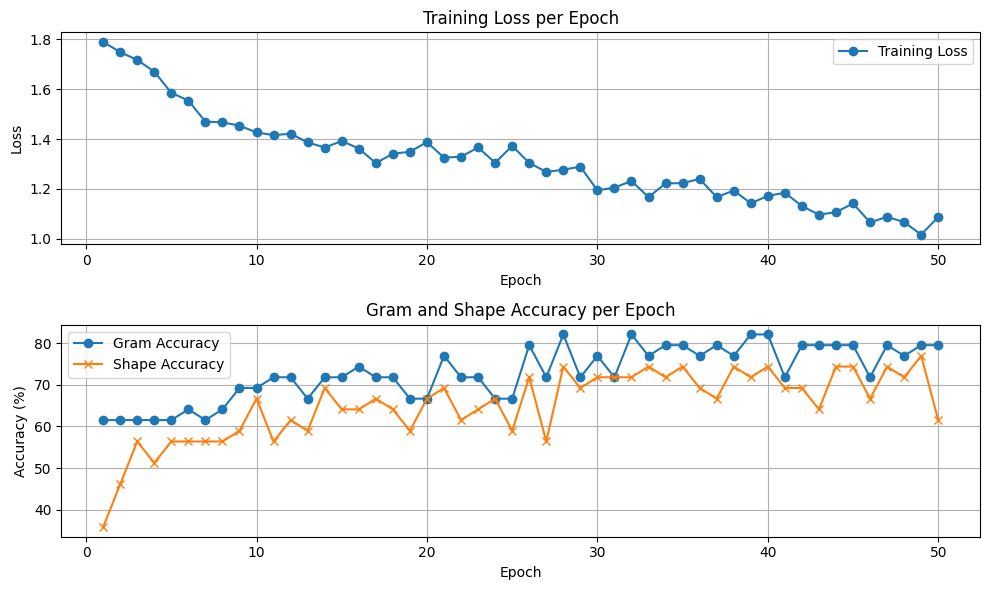

In [ ]:
import matplotlib.pyplot as plt
#print(epoch_losses)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the loss
plt.subplot(2, 1, 1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

# Plot the accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, len(gram_accuracies) + 1), gram_accuracies, label='Gram Accuracy', marker='o')
plt.plot(range(1, len(shape_accuracies) + 1), shape_accuracies, label='Shape Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Gram and Shape Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


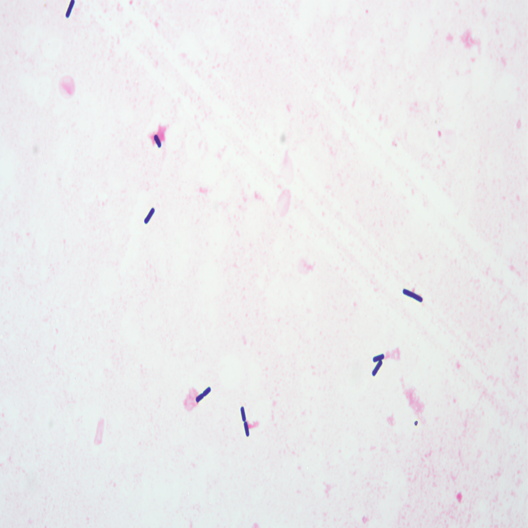

Prediction Summary:
 - Gram Classification: positive
 - Shape: bacilli


In [ ]:
sample_num = 15 # select a random sample

from IPython.display import display

image_tensor, _ = test_dataset_raw.samples[sample_num]  # or use full_train

from PIL import Image
image=Image.open(image_tensor).convert('RGB')
image_tensor=transform_test(image)

with torch.no_grad():
    # Get binary classification result
    output_binary, output_shape = model(image_tensor.unsqueeze(0))  # add batch dim and get both outputs
    pred_binary = torch.argmax(output_binary).item()
    is_positive = (pred_binary == 1)

    # Get shape classification result
    pred_shape = torch.argmax(output_shape).item()

# Labels
binary_label = "positive" if is_positive else "negative"
shape_categories = ['cocci', 'bacilli', 'other']
shape_label = shape_categories[pred_shape]

# Output
image = image.resize((528, 528))
display(image)
print("Prediction Summary:")
print(f" - Gram Classification: {binary_label}")
print(f" - Shape: {shape_label}")